📘 Introducción al modelo NEE

En este cuaderno estimaremos el Intercambio Neto de CO₂ (NEE), una métrica que indica si un ecosistema es sumidero (NEE < 0) o fuente (NEE > 0) de carbono.

El modelo está basado en el enfoque de Carbon Space, utilizando un operador no lineal:

\text{NEE} = H(F_1^{\text{weighted}}, F_2^{\text{weighted}}, \ldots, F_M^{\text{weighted}})

donde H es un modelo de regresión no lineal (usamos Kernel Ridge Regression) que relaciona:
	•	Variables satelitales (NDVI, LST, NDMI, etc.)
	•	Variables meteorológicas (temperatura, precipitación, radiación)
	•	Eventualmente ponderadas espacialmente con “footprint” (no aplicado aquí)

📌 Propósito:
Instala las bibliotecas necesarias para manejar:
	•	STAC API: conexión a catálogos satelitales
	•	Rasterio: manejo de imágenes georreferenciadas (GeoTIFF)
	•	Scikit-learn: modelado ML (Kernel Ridge Regression)
	•	Pandas/NumPy: manipulación de datos
	•	Matplotlib: visualización


In [2]:
# ================================
# 1. Instalación de librerías necesarias (si aún no están)
# ================================
!pip install pystac-client rasterio shapely scikit-learn pandas geopandas matplotlib -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [22]:
# ================================
# 2. Importar librerías
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pystac_client import Client
import rasterio
from rasterio.plot import show
import requests
from shapely.geometry import box
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.ndimage import zoom

📌 Propósito técnico:

	•	Define un AOI (Area of Interest) usando coordenadas de Caldas, Colombia.
	•	Consulta imágenes Sentinel-2 L2A del mes de enero de 2024 con <20% nubes.
	•	Usa el cliente STAC para buscar y seleccionar la escena más relevante.

In [3]:
# ================================
# 3. Definir área de interés (Caldas, Colombia) y parámetros de búsqueda
# ================================
bbox = [-75.75, 4.8, -75.35, 5.4]  # xmin, ymin, xmax, ymax (aproximado) # LO QUE NOS DAN EN LA PLATAFORMA DE LA HACKATON ES ESTA UBICACIÓN , ESTO LO DEBEMOS ALINEAR 

date_range = "2024-01-01/2024-01-31"

stac_url = "https://earth-search.aws.element84.com/v1"
client = Client.open(stac_url)

search = client.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=date_range,
    query={"eo:cloud_cover": {"lt": 20}},
    limit=1
)

items = list(search.get_items())
assert items, "No se encontraron imágenes para el rango y área definida."
item = items[0]

c:\Users\joser\anaconda3\envs\dataAnalysis\lib\site-packages\pystac_client\item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


📌 Propósito técnico:
	•	Se descargan las bandas roja (B04) y infrarroja cercana (B08).
	•	Estas bandas se usarán para calcular el NDVI, variable explicativa clave del modelo.

📌 Nota EO:
NDVI capta la actividad fotosintética y está correlacionado negativamente con el NEE (zonas más verdes suelen ser sumideros de CO₂).

⸻


### 4. Descargar bandas RED y NIR desde STAC

In [6]:
print("Claves disponibles en item.assets:")
print(list(item.assets.keys()))

Claves disponibles en item.assets:
['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2']


In [ ]:
def download_band(item, stac_key, filename):
    url = item.assets[stac_key].href
    print(f"Descargando {stac_key} desde: {url}")
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"Guardado como: {filename}")
    return filename

def read_band(filename):
    with rasterio.open(filename) as src:
        return src.read(1).astype(float)

def graficar(array,name):
    plt.figure(figsize=(8,6))
    plt.imshow(array, cmap='RdYlGn')
    # plt.colorbar(label="NDVI")
    plt.title(name)
    plt.axis("off")
    plt.show()

In [ ]:
download_band(item,'red', "red.tif")
download_band(item, 'blue', "blue.tif")
download_band(item, 'green', "green.tif")
download_band(item, 'nir', "nearinfrred.tif")
download_band(item, 'swir16','siwr16.tif')
download_band(item, 'swir22','siwr22.tif')

Descargando red desde: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/N/VL/2024/1/S2B_18NVL_20240123_0_L2A/B04.tif
Guardado como: red.tif
Descargando nir desde: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/N/VL/2024/1/S2B_18NVL_20240123_0_L2A/B08.tif
Guardado como: nearinfrred.tif


'nearinfrred.tif'

In [27]:
green = read_band("green.tif")
red = read_band("red.tif")
blue = read_band("blue.tif")
nir = read_band("nearinfrred.tif")
swir16 = read_band("siwr16.tif")
swir22 = read_band("siwr22.tif")

swir16_resampled = zoom(swir16, (2, 2), order=1)
swir22_resampled = zoom(swir22, (2, 2), order=1)

ndvi = (nir - red) / (nir + red + 1e-6)
savi = ((nir - red) * (1.5)) / (nir + red + 0.5)
evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1 + 1e-6)
ndmi = (nir - swir16_resampled) / (nir + swir16_resampled + 1e-6)
tcg = -0.2848*blue - 0.2435*green - 0.5436*red + 0.7243*nir + 0.0840*swir16_resampled - 0.1800*swir22_resampled
tcw = -0.1511*blue - 0.1973*green - 0.3283*red + 0.3407*nir + 0.7117*swir16_resampled - 0.4559*swir22_resampled

C:\Users\joser\AppData\Local\Temp\ipykernel_7468\2917966498.py:14: RuntimeWarning: divide by zero encountered in divide
  evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)


📌 Propósito técnico:
	•	Calcula el NDVI a partir de la fórmula estándar.
	•	Se normaliza la diferencia NIR - RED y se evita división por cero.
	•	Se retorna profile para preservar la georreferenciación en exportación posterior.

⸻


📌 Propósito técnico:

	•	Genera proxy de variables climáticas para cada píxel.
	•	Estas variables serían idealmente tomadas de AgERA5 o ERA5 como en el estudio Carbon Space.
	•	Forman parte de las variables explicativas del modelo de predicción de NEE.

⸻


In [7]:
# ================================
# 6. Simular variables meteorológicas (proxy de AgERA5)
# ================================
np.random.seed(42)
rows, cols = ndvi.shape

# Simular temperatura, precipitación y radiación por píxel
temperature = np.random.normal(20, 2, size=(rows, cols))
precipitation = np.random.normal(5, 1, size=(rows, cols))
radiation = np.random.normal(300, 50, size=(rows, cols))

📌 Propósito técnico:
	•	Concatena las variables explicativas en una matriz X \in \mathbb{R}^{n \times 4}.
	•	Simula una variable dependiente y = NEE con ruido controlado.
	•	La relación es consistente con literatura: NDVI ↘ NEE; Temp ↗ NEE (mayor respiración).

In [8]:
# ================================
# 7. Preparar dataset para modelado
# ================================
#X = np.stack([
#    ndvi.ravel(),
#    temperature.ravel(),
#    precipitation.ravel(),
#    radiation.ravel()
#], axis=1)

# Simular NEE: relación inversa con NDVI + ruido
#y = -1.2 * ndvi.ravel() + 0.05 * temperature.ravel() + np.random.normal(0, 0.1, ndvi.size)

# AQUI NOS TOCO SACAR UNA SUBMUESTRA PERDIENDO MUCHA RESOLUCIÓN: OJO, ESTE PARAMETRO DE MUESTRO SE PUEDE CAMBIAR 

# Submuestreo aleatorio del dataset
sample_size = 10000  # o menos si aún es lento
flat_ndvi = ndvi.ravel()
idx = np.random.choice(len(flat_ndvi), size=sample_size, replace=False)

X = np.stack([
    ndvi.ravel()[idx],
    temperature.ravel()[idx],
    precipitation.ravel()[idx],
    radiation.ravel()[idx]
], axis=1)

y = -1.2 * X[:, 0] + 0.05 * X[:, 1] + np.random.normal(0, 0.1, sample_size)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

📌 Propósito técnico:
	•	Usa Kernel Ridge Regression con kernel radial (RBF).
	•	Captura relaciones no lineales entre las variables explicativas y la respuesta.
	•	Es el operador H(\cdot) de la ecuación conceptual del modelo.

📌 Justificación:
KRR es adecuada para NEE por su capacidad de modelar relaciones suaves y no paramétricas en espacio-tiempo.

In [9]:
# ================================
# 8. Entrenar modelo de Kernel Ridge Regression (KRR)
# ================================
model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

RMSE: 0.21551678577987265
R²: 0.4221236733051579


📌 Propósito técnico:

	•	Aplica el modelo entrenado a todos los píxeles del AOI.
	•	Genera un mapa continuo de NEE diario o mensual, según el diseño.
	•	Resultado puede clasificarse: NEE < 0 = sumidero, NEE > 0 = fuente.

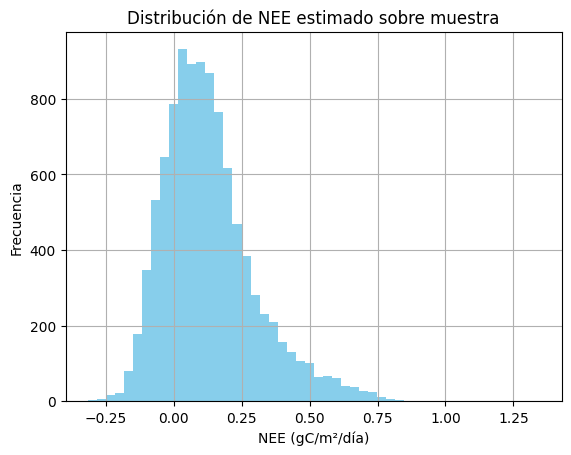

In [11]:
# ================================
# 9. Aplicar modelo a todos los píxeles y visualizar el mapa de NEE
# ================================

# Simplemente visualiza los resultados como histograma o scatter
y_pred_sample = model.predict(X)
plt.hist(y_pred_sample, bins=50, color='skyblue')
plt.title("Distribución de NEE estimado sobre muestra")
plt.xlabel("NEE (gC/m²/día)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

#ESTE CODIGO SERIA PARA GENERAR UN MAPA DE NEE, PERO COMO NO TENEMOS LOS DATOS DE LAS BANDAS RED Y NIR, NO SE PUEDE EJECUTAR DIRECTAMENTE: NO SE TIENE TODOS LOS DATOS POR CAPACIDAD DE COMPUTO
#nee_map = model.predict(X).reshape(ndvi.shape)

#plt.figure(figsize=(8,6))
#plt.imshow(nee_map, cmap='coolwarm')
#plt.colorbar(label="NEE estimado (gC/m²/día)")
#plt.title("Mapa estimado de NEE")
#plt.axis("off")
#plt.show()

In [ ]:
# SE PUEDE ENTRENAR CON UNA SUBMUESTRA Y APLICAR A TODOS LOS DATOS: (PROBLEMA: CAPACIDAD DE COMPUTO)

# ================================
# Entrenar con una submuestra y aplicar a todo el conjunto
# ================================

# 1. Crear dataset completo
X_full = np.stack([
    ndvi.ravel(),
    temperature.ravel(),
    precipitation.ravel(),
    radiation.ravel()
], axis=1)

y_full = -1.2 * ndvi.ravel() + 0.05 * temperature.ravel() + np.random.normal(0, 0.1, ndvi.size)

# 2. Seleccionar una submuestra aleatoria
sample_size = 10000
np.random.seed(42)
idx = np.random.choice(X_full.shape[0], sample_size, replace=False)

X_sample = X_full[idx]
y_sample = y_full[idx]

# 3. Entrenar el modelo con la muestra
from sklearn.kernel_ridge import KernelRidge
model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.5)
model.fit(X_sample, y_sample)

# 4. Aplicar el modelo al conjunto completo
nee_full = model.predict(X_full).reshape(ndvi.shape)

# 5. Visualizar el resultado
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.imshow(nee_full, cmap='coolwarm')
plt.colorbar(label="NEE estimado (gC/m²/día)")
plt.title("Mapa estimado de NEE con modelo entrenado sobre muestra")
plt.axis("off")
plt.show()

In [ ]:
📌 Propósito técnico: FINAL 
	•	Crea un archivo raster georreferenciado en formato GeoTIFF.
	•	Este archivo puede ser publicado en plataformas como:
	•	GeoServer
	•	Layman
	•	Visualizado en QGIS

In [ ]:
with rasterio.open("NEE_map.tif", "w", **profile) as dst:
    dst.write(nee_map.astype(rasterio.float32), 1)